In [141]:
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [142]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [143]:
print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_test: {y_test.shape}')

X_train: (60000, 28, 28)
y_train: (60000,)
X_test: (10000, 28, 28)
y_test: (10000,)


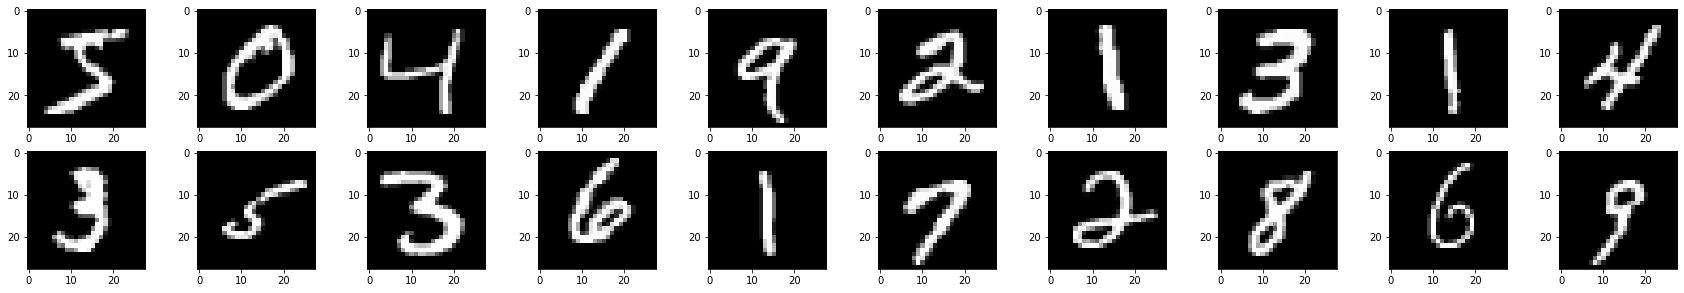

In [144]:
plt.figure(figsize=(30, 10))
for i in range(20):
    plt.subplot(4,10,i+1)
    plt.imshow(X_train[i,:].reshape([28,28]), cmap='gray')

In [145]:
X_train = X_train.reshape((60000, 28, 28, 1))
X_test = X_test.reshape((10000, 28, 28, 1))

print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')


X_train: (60000, 28, 28, 1)
X_test: (10000, 28, 28, 1)


In [146]:
# Преобразовали данные от 0 до 1, тип данных float
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

Модуль tensorflow.keras.utils предоставляет функцию to_categorical
для выполнения прямого унитарного кодирования. Функция подсчитывает

уникальные категории, а затем для каждого закодированного элемента соз-
дает массив соответствующей длины со значением 1.0 в нужной позиции.

Преобразуем y_train и y_test из одномерных массивов со значениями 0–9
в двумерные массивы категорийных данных. После этого строки массивов
будут выглядеть так, как показано выше. Фрагмент [21] выводит категорийные
данные одного образца для цифры 5 (напомним, что NumPy выводит точку, но
не выводит завершающие нули в значениях с плавающей точкой):

In [147]:
 from tensorflow.keras.utils import to_categorical

In [148]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print(f'y_train: {y_train.shape}')
print(f'y_test: {y_test.shape}')

y_train: (60000, 10)
y_test: (10000, 10)


15.6.4. Создание нейронной сети


Итак, данные подготовлены, и мы можем переходить к настройке сверточной 
нейронной сети. Начнем с модели Keras Sequential из модуля tensorflow.
keras.models: 

In [149]:
from tensorflow.keras.models import Sequential

In [150]:
cnn = Sequential()

Полученная сеть будет выполнять свои уровни последовательно — выход 
одного уровня станет входом другого; такие сети также называются сетями 
прямого распространения. Как будет показано при обсуждении рекуррентных 
нейронных сетей, не все нейронные сети работают по этому принципу.

Типичная сверточная нейронная сеть состоит из нескольких уровней — входного уровня, получающего обучающие образцы скрытых уровней, которые 
обучаются по образцам, и выходного уровня, генерирующего вероятности 
прогнозов. Теперь создадим простейшую сверточную сеть. Импортируем из 
модуля tensorflow.keras.layers классы уровней, которые будут использоваться в этом примере:

In [151]:
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D

Добавление сверточного уровня
Добавим в модель сверточный уровень Conv2D:

In [152]:
cnn.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))

Уровень Conv2D настраивается следующими аргументами:

Ø filters=64 — количество фильтров в итоговой карте признаков;

Ø kernel_size=(3, 3) — размер ядра, используемого в каждом фильтре;

Ø activation='relu' — для получения вывода уровня используется функция активации 'relu' (Rectified Linear Unit). 'relu' — наиболее часто 
используемая функция активации в современных сетях глубокого обучения2
; она просто вычисляется, что хорошо отражается на быстродействии3
. Чаще всего для сверточных уровней рекомендуется использовать 
именно эту функцию4.

Tак как это первый уровень модели, мы также передаем аргумент input_
shape=(28, 28,1) для определения размерности каждого образца. При этом 
автоматически создается входной уровень для загрузки образцов и передачи их 
уровню Conv2D, который является первым скрытым уровнем. В Keras каждый 
последующий уровень определяет свое значение input_shape по выходным 
данным предыдущего уровня, что упрощает наложение уровней. 

In [153]:
#Выход предыдущего уровня сокращается с 26 × 26 × 64 до 13 × 13 × 641.
cnn.add(MaxPooling2D(pool_size=(2, 2)))
# Добавим второй сверточный уровень со 128 фильтрами, за которым следует второй объединяющий уровень для сокращения степени размерности на 75%:
cnn.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))

Входом второго сверточного уровня является выход 13 × 13 × 64 первого 
объединяющего уровня. Таким образом, выход фрагмента [29] будет иметь 
размеры 11 × 11 × 128. Для нечетных размеров (например, 11 × 11) объединяющие уровни Keras по умолчанию используют округление вниз (в данном случае до 11 × 11), так что выход этого объединяющего уровня будет иметь 
размеры 5 × 5 × 128.

На текущий момент выход предыдущего уровня является трехмерным 
(5 × 5 × 128), но на выходе модель должна выдавать одномерный массив 10 вероятностей классификации цифр. Для подготовки одномерных прогнозов 
сначала необходимо преобразовать трехмерный выход предыдущего уровня 
к одному измерению. Уровень Keras Flatten преобразует свой вход к одному 
измерению. В данном случае выход уровня Flatten будет иметь размеры 
1 × 3200 (то есть 5*5*128):


In [154]:
cnn.add(Flatten())

Добавление уровня Dense для сокращения 
количества признаков

Уровни, предшествующие уровню Flatten, изучали признаки цифр. Теперь 
необходимо взять все эти признаки и изучить отношения между ними, чтобы 
наша модель могла определить, какую цифру представляет то или иное изображение. Изучение отношений между признаками и проведение классификации достигается в полносвязных уровнях Dense наподобие изображенных 
на диаграмме нейронной сети ранее в этой главе. Следующий уровень Dense
создает 128 нейронов (блоков), обучающихся на 3200 выходных значениях 
предыдущего уровня:

In [155]:
cnn.add(Dense(units=128, activation='relu'))

Добавление еще одного уровня Dense для получения 
итогового результата

Последним уровнем нашей сети будет уровень Dense, который классифицирует 
свои входные данные по нейронам, представляющим классы от 0 до 9. Функция 
активации softmax преобразует значения 10 нейронов в классификационные 
вероятности. Нейрон, производящий наибольшую вероятность, представляет 
прогноз для заданного изображения:

In [156]:
cnn.add(Dense(units=10, activation='softmax'))

Метод summary модели выводит информацию об уровнях модели. В частности, 
здесь можно найти интересную информацию о размерах выходных данных 
разных уровней и количестве параметров.

In [157]:
cnn.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 11, 11, 128)       73856     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 5, 5, 128)        0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 3200)              0         
                                                                 
 dense_8 (Dense)             (None, 128)              

После сохранения результата в файле convnet.png мы используем класс Image
модуля IPython.display для отображения результата в документе Notebook. 
Keras назначает имена уровней на диаграмме2
:

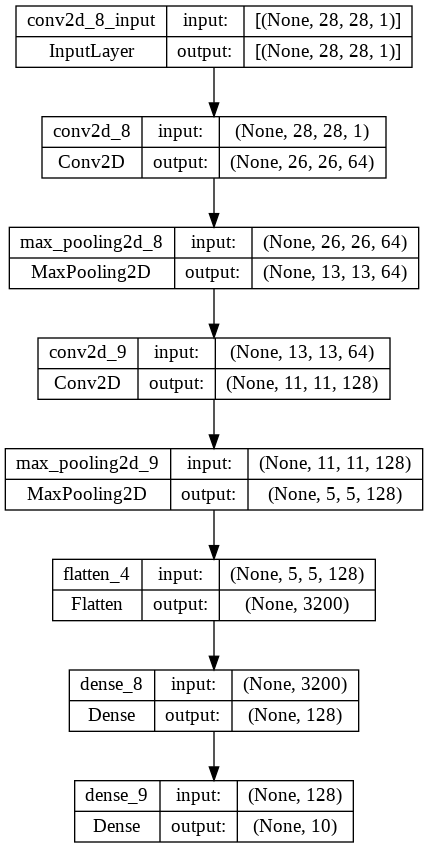

In [158]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

plot_model(cnn, to_file='convnet.png', show_shapes=True, 
show_layer_names=True)
Image(filename='convnet.png')

Компиляция модели

После добавления всех уровней построение модели завершается вызовом 
метода compile:

In [159]:
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Аргументы:

Ø optimizer='adam' — оптимизатор, используемый моделью для регулировки весов в нейронной сети в процессе обучения. Отметим, что существует много подходящих оптимизаторов1
, в частности, 'adam' показывает неплохие результаты в широком спектре моделей2,3
.

Ø loss='categorical_crossentropy' — функция потерь, используемая оптимизатором в сетях множественной классификации (таких, как наша 
сверточная сеть), которая будет прогнозировать 10 классов. В процессе 
обучения нейронной сети оптимизатор пытается минимизировать значения, возвращаемые функцией потерь. Чем ниже потери, тем лучше 
справляется нейронная сеть с прогнозированием. Для бинарной классификации (которая будет использоваться позднее в этой главе) Keras 
предоставляет функцию 'binary_crossentropy', а для регрессии — 'mean_
squared_error'. За информацией о других функциях потерь обращайтесь 
по адресу:
https://keras.io/losses/.

Ø metrics=['accuracy'] — список метрик, которые будут производиться 
сетью, для того чтобы упростить вам оценку модели. Точность — популярная метрика, часто используемая в классификационных моделях. В этом 
примере мы воспользуемся метрикой точности для проверки процента 
правильных прогнозов. Список других метрик доступен по адресу:
https://keras.io/metrics/

**15.6.5. Обучение и оценка модели**

По аналогии с моделями scikit-learn обучим модель Keras вызовом ее метода fit:

Ø Как и в Scikit-learn, в первых двух аргументах передаются обучающие 
данные и категорийные метки целей.

Ø Аргумент epochs сообщает, сколько раз модель должна обработать весь 
набор обучающих данных. Напомним, обучение нейронных сетей проходит в итеративном режиме.

Ø Аргумент batch_size задает количество образцов, обрабатываемых за 
один раз в каждой эпохе. Для большинства моделей выбирается степень 2 от 32 до 512. Более высокие значения могут привести к снижению точности модели1
. Мы выбрали значение 64. Вы можете опробовать разные значения и определить, как они влияют на эффективность 
модели.

Ø В общем случае некоторые образцы должны использоваться для проверки модели. Если вы укажете проверочные данные, то после каждой эпохи 
модель использует их для построения прогнозов и вывода проверочных 
значений потерь и точности. Вы можете изучить эти модели для настройки ваших уровней и гиперпараметров метода fit или, возможно, для изменения структуры уровней модели. В данном случае мы использовали 
аргумент validation_split для обозначения того, что модель должна зарезервировать последние 10% (0.1) обучающих образцов для проверки2
, — 
в данном случае 6000 образцов будут использованы для проверки. Если 
у вас имеются отдельные проверочные данные, то аргумент validation_
data (см. раздел 15.9) может использоваться для передачи кортежа с массивами образцов и целевых меток. В общем случае лучше использовать 
случайно выбранные проверочные данные. Для этой цели можно воспользоваться функцией train_test_split библиотеки scikit-learn (как это будет сделано позднее в этой главе), после чего передать случайно выбранные данные в аргументе validation_data.

В следующем выводе точность обучения (acc) и точность проверки (val_acc) 
выделены жирным шрифтом:

In [160]:
cnn.fit(X_train, y_train, epochs=5, batch_size=15, validation_split=0.1)

Epoch 1/5
3600/3600 [==============================] - 14s 4ms/step - loss: 0.1072 - accuracy: 0.9664 - val_loss: 0.0404 - val_accuracy: 0.9882
Epoch 2/5
3600/3600 [==============================] - 13s 4ms/step - loss: 0.0411 - accuracy: 0.9871 - val_loss: 0.0511 - val_accuracy: 0.9862
Epoch 3/5
3600/3600 [==============================] - 13s 4ms/step - loss: 0.0265 - accuracy: 0.9914 - val_loss: 0.0439 - val_accuracy: 0.9877
Epoch 4/5
3600/3600 [==============================] - 13s 4ms/step - loss: 0.0193 - accuracy: 0.9938 - val_loss: 0.0344 - val_accuracy: 0.9915
Epoch 5/5
3600/3600 [==============================] - 13s 4ms/step - loss: 0.0134 - accuracy: 0.9957 - val_loss: 0.0464 - val_accuracy: 0.9902


В процессе обучения метод fit выводит различную информацию: прогресс
каждой эпохи, длительность выполнения эпохи (в нашем случае каждая зани-
мала 63–70 секунд) и оценочные метрики для текущего прохода. В последней
эпохе этой модели точность достигла 99,48% для обучающих образцов (acc)
и 99,27% для проверочных образцов (val_acc). Впечатляющие показатели,
особенно если учесть, что мы еще не пытались настраивать гиперпараметры
или подбирать количество и типы уровней, что может улучшить (или ухуд-
шить) результаты. Как и машинное обучение, глубокое обучение является
эмпирической дисциплиной, в которой большое количество экспериментов
приносит пользу.

**Оценка модели**

Теперь точность модели можно проверить на данных, неизвестных модели.
Для этого вызовем метод evaluate модели, который выводит продолжительность обработки тестовых образцов (4 секунды и 366 микросекунд в данном
случае):

In [161]:
loss, accuracy = cnn.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.0393 - accuracy: 0.9895


In [162]:
print(f'loss: {loss:.4}')
print(f'accuracy: {accuracy:.4}')

loss: 0.03933
accuracy: 0.9895


Из этого вывода следует, что наша модель сверточных нейронных сетей обеспе-
чивает точность 99,17% при прогнозировании меток для незнакомых данных,
хотя мы еще даже не пытались настраивать модель. Поиски в интернете по-
зволяют отыскать модели, способные прогнозировать данные MNIST с почти
100-процентной точностью. Попробуйте поэкспериментировать с разными
уровнями, типами уровней и их параметрами, наблюдая за тем, как эти из-
менения влияют на результаты.

**Построение прогнозов**

Метод predict модели прогнозирует классы изображений цифр из своего
аргумента-массива (X_test):

In [163]:
y_pred = cnn.predict(X_test)

313/313 [==============================] - 1s 2ms/step


In [164]:
y_test[1]

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [165]:
for index, probability in enumerate(y_pred[2]):
  print(f'{index}: {probability:.0%}')

0: 0%
1: 100%
2: 0%
3: 0%
4: 0%
5: 0%
6: 0%
7: 0%
8: 0%
9: 0%


**Поиск неправильных прогнозов**

Прежде чем просматривать ошибочные прогнозы, необходимо их найти.
Возьмем приведенную выше строку predictions[0]. Чтобы определить, был
ли прогноз правильным, необходимо сравнить индекс наибольшей вероят-
ности в predictions[0] с индексом элемента, содержащего 1.0 в y_test[0].

Если значения индексов совпадают, то прогноз правильный; в противном
случае он ошибочен. Функция argmax библиотеки NumPy определяет ин-
декс элемента с наибольшим значением в своем аргументе-массиве. Вос-
пользуемся этой функцией для поиска ошибочных прогнозов. В следующем
фрагменте p — массив прогнозируемых значений, а e — массив ожидаемых
значений (ожидаемыми значениями являются метки тестовых изображений
из набора данных):

In [166]:
images = X_test.reshape((10000, 28, 28))
incorrect_predictions = []

for i, (p, e) in enumerate(zip(y_pred, y_test)):
  predicted, expected = np.argmax(p), np.argmax(e)
  if predicted != expected:
    incorrect_predictions.append(
    (i, images[i], predicted, expected))

В этом фрагменте мы сначала изменим размеры (28, 28, 1), необходимые Keras
для обучения, до (28, 28), требуемых Matplotlib для вывода изображений. За-
тем список incorrect_predictions заполняется в цикле for. Мы упаковываем
строки данных, представляющие каждый образец в массивах predictions
и y_test, а затем перебираем их для сохранения индексов. Если результаты
argmax для p и e различные, то это означает, что прогноз ошибочен, и к списку
incorrect_predictions присоединяется кортеж с индексом образца, изобра-
жением, прогнозируемым и ожидаемым значением. Следующий фрагмент
проверяет общее количество ошибочных прогнозов (из 10 000 изображений
тестового набора):

**Визуализация ошибочных предсказаний**

Следующий фрагмент выводит 24 неправильных изображения с указанием
индекса каждого изображения (index), прогнозируемого значения (p) и ожи-
даемого значения (e):

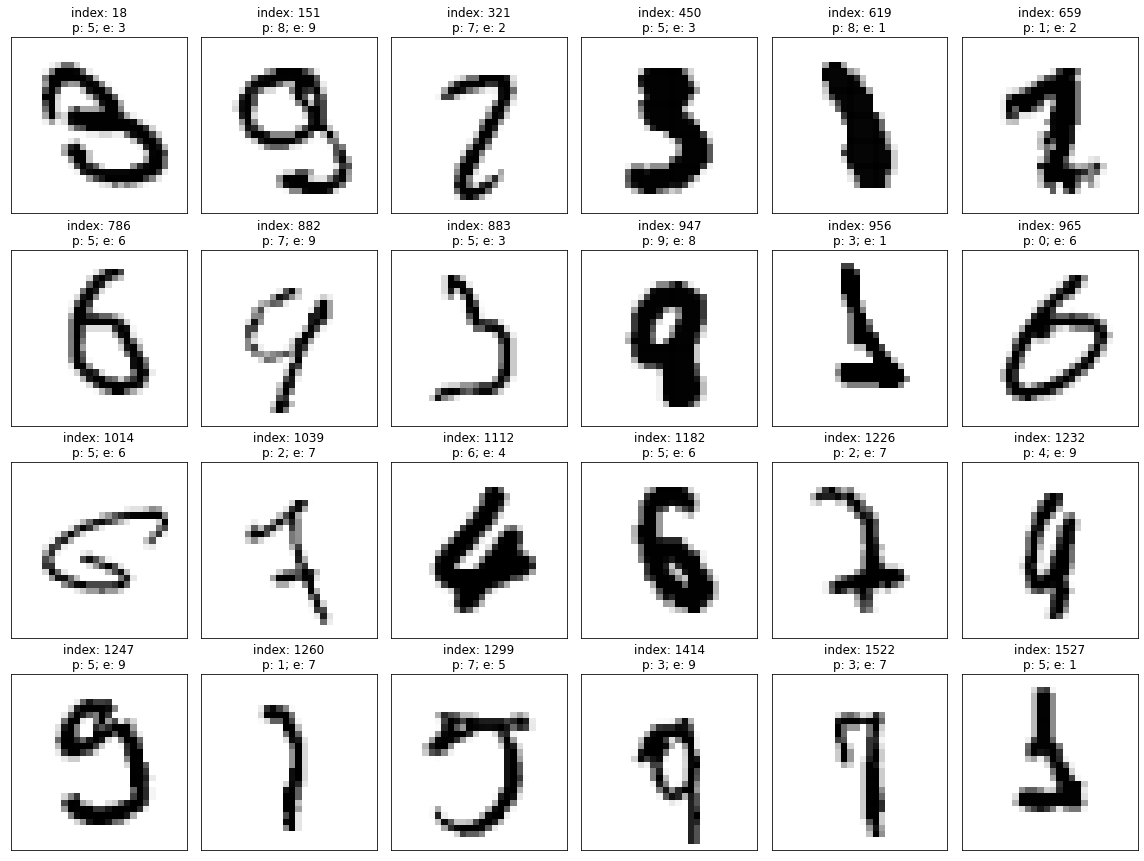

In [167]:
figure, axes = plt.subplots(nrows=4, ncols=6, figsize=(16, 12))
for axes, item in zip(axes.ravel(), incorrect_predictions):
  index, image, predicted, expected = item
  axes.imshow(image, cmap=plt.cm.gray_r)
  axes.set_xticks([]) # remove x-axis tick marks
  axes.set_yticks([]) # remove y-axis tick marks
  axes.set_title(f'index: {index}\np: {predicted}; e: {expected}')
plt.tight_layout()

**Вывод вероятностей для нескольких ошибочных прогнозов**

Просмотрим вероятности нескольких ошибочных прогнозов. Следующая
функция выводит вероятности заданного массива прогнозов:

In [168]:
def display_probabilities(prediction):
  for index, probability in enumerate(prediction):
    print(f'{index}: {probability:.10%}')

Хотя изображение 8 (с индексом 495) в первой строке вывода похоже на 8,
у нашей модели возникли с ней затруднения. Как видно из следующего вывода,
модель спрогнозировала это значение как 0, но также полагала, что с 16-процентной вероятностью это может быть 6, а с 23-процентной вероятностью — 8:

In [169]:
display_probabilities(y_pred[18])

0: 0.0007259612%
1: 0.0000956668%
2: 0.0056214441%
3: 43.8885867596%
4: 0.0000009141%
5: 54.4435143471%
6: 0.0000549615%
7: 0.0000018711%
8: 1.6610248014%
9: 0.0003708915%


Изображение 2 (с индексом 583) в первой строке спрогнозировано как 7 с вероятностью 62,7%, но модель также считала, что с 36,4-процентной вероятностью
это может быть цифра 2:

In [172]:
display_probabilities(y_pred[1014])

0: 0.0056881596%
1: 0.0000000046%
2: 0.0000047885%
3: 0.0009351044%
4: 0.0000000777%
5: 99.8869836330%
6: 0.1008345629%
7: 0.0000000312%
8: 0.0055426859%
9: 0.0000047668%


**15.6.6. Сохранение и загрузка модели**

Обучение моделей нейронных сетей может потребовать значительного времени. После того как вы спроектируете и протестируете подходящую модель,
можно сохранить ее состояние. Это позволит вам загрузить ее в будущем
для построения новых прогнозов. Иногда модели загружаются и проходят
дальнейшее обучение для новых задач. Например, уровни нашей модели уже
умеют распознавать такие признаки, как линии и кривые, которые также могут
пригодиться для распознавания рукописных символов (как в наборе данных
EMNIST). Таким образом, теоретически вы можете загрузить существующую
модель и использовать ее как основу для построения более мощной модели. 

Этот процесс называется переносом обучения1,2 — знания существующей
модели переносятся в новую модель. Метод save моделей Keras сохраняет
архитектуру модели и информацию состояния в формате HDF5 (Hierarchical
Data Format). Такие файлы по умолчанию используют расширение .h5:

In [173]:
cnn.save('mnist_cnn.h5')

Сохраненную модель можно загрузить функцией load_model из модуля
tensorflow.keras.models:

In [177]:
from tensorflow.keras.models import load_model
cnn = load_model('mnist_cnn.h5')

После этого вы сможете вызывать методы модели. Например, при появлении
дополнительных данных можно вызвать метод predict для построения новых
прогнозов для новых данных или же вызвать fit, чтобы начать обучение с дополнительными данными. 